In [ ]:
import re
import urllib.parse
import pandas as pd
from typing import List

In [ ]:
class LogProcessor:
    def __init__(self):
        self.patterns = {
            "sql_injection": re.compile(
                r"(?i)(\b(select|union|insert|delete|update|drop|sleep|benchmark|waitfor|or\s+1=1|pg_sleep)\b|--|%27|'|\bconcat\b|\binformation_schema\b)"
            ),
            "xss": re.compile(
                r"(?i)(<script|on\w+=|alert\(|prompt\(|confirm\(|%3Cscript|javascript:)"
            ),
            "command_injection": re.compile(
                r"(?i)(\b(exec\s*\(|system\s*\(|shell_exec\s*\(|popen|cmd|powershell|curl\s|wget\s|\$\(|%24%28|;|&&|\|\|)\b)"
            ),
            "path_traversal": re.compile(
                r"(?i)(\.\./|\.\.\\|%2e%2e%2f|%2e%2e\\|etc/passwd|boot.ini|win.ini)"
            ),
        }

    def parse_logs(self, log_lines: List[str]) -> pd.DataFrame:
        """
        Parses Apache/Nginx-style logs and returns a DataFrame.
        """
        log_pattern = re.compile(
            r'(?P<ip>\S+) - - \[(?P<timestamp>[^\]]+)\] '
            r'"(?P<method>\S+)\s(?P<url>\S+)\s(?P<protocol>[^"]+)" '
            r'(?P<status>\d{3}) (?P<size>\d+) '
            r'"(?P<referrer>[^"]*)" "(?P<user_agent>[^"]*)"'
        )

        parsed = []
        for line in log_lines:
            match = log_pattern.search(line)
            if match:
                parsed.append(match.groupdict())

        return pd.DataFrame(parsed)

    def label_log_row(self, text: str) -> str:
        """
        Detects attacks using the combined URL + Referrer string.
        Automatically labels static files as 'normal'.
        """
        decoded = urllib.parse.unquote(text.lower().strip())

        # === 1. Static file filter ===
        static_extensions = (".js", ".css", ".png", ".jpg", ".jpeg", ".gif", ".ico", ".svg", ".woff", ".ttf", ".eot")
        if decoded.endswith(static_extensions):
            return "normal"

        # === 2. Attack detection in order of priority ===
        # XSS first
        if self.patterns["xss"].search(decoded):
            return "xss"
        # SQL Injection
        if self.patterns["sql_injection"].search(decoded):
            return "sql_injection"
        # Command Injection (based on updated regex)
        if self.patterns["command_injection"].search(decoded):
            return "command_injection"
        # Path Traversal
        if self.patterns["path_traversal"].search(decoded):
            return "path_traversal"

        return "normal"

    def process_logs(self, log_lines: List[str]) -> pd.DataFrame:
        """
        Parses logs and adds an attack label to each row.
        Attack detection is performed by combining url + referrer.
        If referrer is '-', it is ignored.
        """
        df = self.parse_logs(log_lines)

        # Remove unnecessary requests, such as homepage requests
        df = df[~df["url"].isin(["/"])]

        # Replace referrer "-" with empty string
        df["referrer"] = df["referrer"].replace("-", "")

        # Also treat null values as empty strings
        df["url"] = df["url"].fillna("")
        df["referrer"] = df["referrer"].fillna("")

        # Combine url + referrer for attack detection
        combined = df["url"] + " " + df["referrer"]

        df["label"] = combined.apply(self.label_log_row)

        return df

    def save_to_csv(self, df: pd.DataFrame, path: str):
        """Saves the data as a CSV file."""
        df.to_csv(path, index=False)
        print(f"[✓] CSV saved successfully: {path}")

    def load_from_csv(self, path: str) -> pd.DataFrame:
        """Loads data from a CSV file."""
        return pd.read_csv(path)

    def read_logs_from_file(self, file_path: str) -> List[str]:
        """Reads log lines from a file and returns a list."""
        with open(file_path, encoding="utf-8") as f:
            lines = f.readlines()
            return lines

    def process_log_file(self, file_path: str, output_csv: str = "log_dataset.csv"):
        """Starts reading, processing, and saving logs from a file."""
        with open(file_path, encoding="utf-8") as f:
            lines = f.readlines()
        df = self.process_logs(lines)
        self.save_to_csv(df, output_csv)

    def process_new_logs(self, new_logs: List[str]) -> pd.DataFrame:
        """Processes new logs for model inference or analysis."""
        return self.process_logs(new_logs)

In [ ]:
# Connec to the drive
from google.colab import drive
drive.mount('/content/drive')
# Paths
BASE_PATH = '/content/drive/MyDrive/'
DATA_SET_PATH = BASE_PATH + 'Capstone Project/Datasets/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files

def download_csv(df, file_name):
    df.to_csv(file_name, index=False)
    files.download(file_name)

In [ ]:
# İnitialize log processor
log_processor = LogProcessor()

In [ ]:
acunetix_logs_path = DATA_SET_PATH + 'acunetix.txt'
w3af_logs_path = DATA_SET_PATH + 'w3af.txt'
netsparker_logs_path = DATA_SET_PATH + 'netsparker.txt'

In [ ]:
acunetix_logs = log_processor.read_logs_from_file(acunetix_logs_path)
acunetix_df = log_processor.process_logs(acunetix_logs)
#acunetix_df.head(50)
# show only (url, referrer, label)
acunetix_df = acunetix_df[['url', 'referrer', 'label']]
acunetix_df.head(200)

,url,referrer,label
0,/administrator/index.php,http://192.168.4.161/DVWA,normal
1,/index.php/component/search/,,normal
2,/index.php/component/search/,http://192.168.4.161/DVWA,normal
3,/index.php/component/search/,http://192.168.4.161/DVWA,normal
4,/index.php/component/search/,,normal
...,...,...,...
197,/index.php/component/search/,http://192.168.4.161/DVWA,normal
198,/index.php/component/search/,http://192.168.4.161/DVWA,normal
199,/index.php/component/search/,http://192.168.4.161/DVWA,normal
200,/index.php/component/search/,,normal


In [ ]:
w3af_logs = log_processor.read_logs_from_file(w3af_logs_path)
w3af_df = log_processor.process_logs(w3af_logs)
#w3af_df.head(50)
# show only (url, referrer, label)
w3af_df = w3af_df[['url', 'referrer', 'label']]
w3af_df.head(200)


,url,referrer,label
17,/4MlfjsG9.py,,normal
18,/7Vi0ho7m.foobar,,normal
19,/avA6ymqj.php,,normal
20,/cdcZMNEA.cgi,,normal
21,/HD7rYCqF.gif,,normal
...,...,...,...
215,/index.php/component/users/,http://192.168.4.161/,normal
216,/index.php/component/users/?task=3mmzm%3C%2F-%...,http://192.168.4.161/,sql_injection
217,/index.php/component/users/?task=registration....,http://192.168.4.161/,normal
218,/DVWA/dvwa/css/help.css,http://192.168.4.161/,normal


In [ ]:
netsparker_logs = log_processor.read_logs_from_file(netsparker_logs_path)
netsparker_df = log_processor.process_logs(netsparker_logs)
#netsparker_df.head(50)
# show only (url, referrer, label)
netsparker_df = netsparker_df[['url', 'referrer', 'label']]
netsparker_df.tail(200)

,url,referrer,label
6890,/DVWA/vulnerabilities/exec/,http://192.168.4.161/DVWA/vulnerabilities/exec/,normal
6891,/DVWA/vulnerabilities/exec/,http://192.168.4.161/DVWA/vulnerabilities/exec/,normal
6892,/DVWA/vulnerabilities/exec/,http://192.168.4.161/DVWA/vulnerabilities/exec/,normal
6893,/DVWA/vulnerabilities/exec/,http://192.168.4.161/DVWA/vulnerabilities/exec/,normal
6894,/DVWA/vulnerabilities/exec/,http://192.168.4.161/DVWA/vulnerabilities/exec/,normal
...,...,...,...
7085,/DVWA/vulnerabilities/exec/,http://192.168.4.161/DVWA/vulnerabilities/exec/,normal
7086,/DVWA/vulnerabilities/exec/,http://192.168.4.161/DVWA/vulnerabilities/exec/,normal
7087,/DVWA/vulnerabilities/exec/,http://192.168.4.161/DVWA/vulnerabilities/exec/,normal
7088,/DVWA/vulnerabilities/exec/,http://192.168.4.161/DVWA/vulnerabilities/exec/,normal


In [ ]:
# acunetix download
download_csv(acunetix_df, 'acunetix_df_labeled.csv')

In [ ]:
# w3af download
download_csv(w3af_df, 'w3af_df_labeled.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# netsparker download
download_csv(netsparker_df, 'netsparker_df_labeled.csv')

In [ ]:
# save acunetix
log_processor.save_to_csv(acunetix_df,  DATA_SET_PATH +'acunetix_df_labeled.csv')

[✓] CSV başarıyla kaydedildi: /content/drive/MyDrive/Capstone Project/Datasets/acunetix_df_labeled.csv


In [ ]:
# save w3af
log_processor.save_to_csv(w3af_df,  DATA_SET_PATH +'w3af_df_labeled.csv')

[✓] CSV başarıyla kaydedildi: /content/drive/MyDrive/Capstone Project/Datasets/w3af_df_labeled.csv


In [ ]:
# save netsparker
log_processor.save_to_csv(netsparker_df,  DATA_SET_PATH +'netsparker_df_labeled.csv')

[✓] CSV başarıyla kaydedildi: /content/drive/MyDrive/Capstone Project/Datasets/netsparker_df_labeled.csv


In [ ]:
# combine df tables
combined_df = pd.concat([acunetix_df, w3af_df, netsparker_df], ignore_index=True)
log_processor.save_to_csv(combined_df,  DATA_SET_PATH +'combined_df_labeled.csv')

[✓] CSV başarıyla kaydedildi: /content/drive/MyDrive/Capstone Project/Datasets/combined_df_labeled.csv


In [ ]:
# download combined df
download_csv(combined_df, 'combined_df_labeled.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

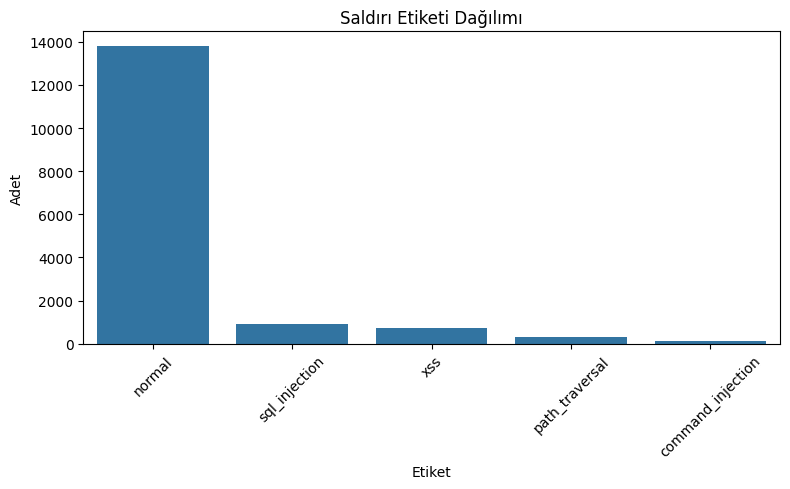

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=combined_df, x="label", order=combined_df["label"].value_counts().index)
plt.title("Saldırı Etiketi Dağılımı")
plt.xlabel("Etiket")
plt.ylabel("Adet")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# balanced df
from sklearn.utils import resample

# Get all attack data (everything that is not labeled as "normal")
attack_df = combined_df[combined_df["label"] != "normal"]

# Get all normal data
normal_df = combined_df[combined_df["label"] == "normal"]

# Get the total number of attack samples
total_attacks = len(attack_df)

# Take a sample from normal data equal to number of attack samples (downsampling)
balanced_normal_df = resample(normal_df,
                              replace=False,
                              n_samples=3000,
                              random_state=42)

# Create a balanced dataset by combining attack and sampled normal data
balanced_df = pd.concat([attack_df, balanced_normal_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# Check class distribution
balanced_distribution = balanced_df["label"].value_counts()

balanced_df.shape, balanced_distribution


((5046, 3),
 label
 normal               3000
 sql_injection         938
 xss                   707
 path_traversal        295
 command_injection     106
 Name: count, dtype: int64)

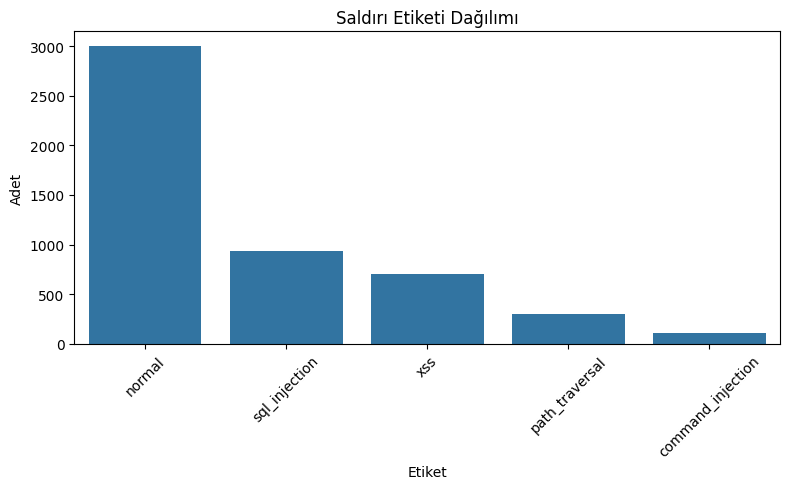

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=balanced_df, x="label", order=combined_df["label"].value_counts().index)
plt.title("Saldırı Etiketi Dağılımı")
plt.xlabel("Etiket")
plt.ylabel("Adet")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# save balanced and download
log_processor.save_to_csv(balanced_df,  DATA_SET_PATH +'balanced_df_labeled.csv')
download_csv(balanced_df, 'balanced_df_labeled.csv')

[✓] CSV başarıyla kaydedildi: /content/drive/MyDrive/Capstone Project/Datasets/balanced_df_labeled.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>